In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import  Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [ ]:
dataset = pd.read_csv('IMDB Dataset.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

In [ ]:
#Text wrangling and normalization
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
        norm_docs.append(doc)

    return norm_docs





In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:13<00:00, 1153.43it/s]

CPU times: user 30.2 s, sys: 326 ms, total: 30.5 s
Wall time: 33.3 s


In [ ]:
t = Tokenizer(oov_token='<UNK>')
#fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175795), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175796
Number of Documents=35000


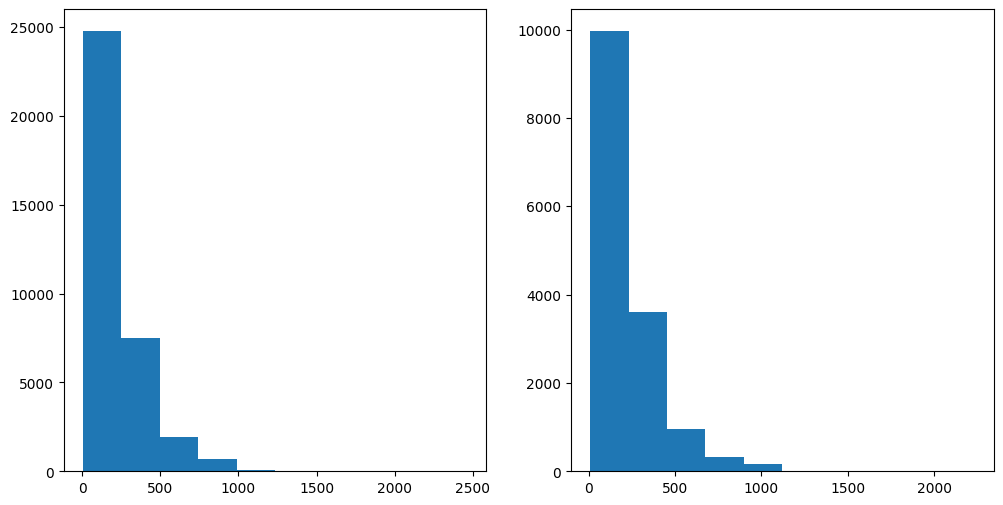

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative ->

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 300
EPOCHS=5
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, 1000))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1000, 300)      │    52,738,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1000, 128)      │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 500, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 250, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,958,097 (205.83 MB)

 Trainable params: 53,958,097 (205.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1079s 4s/step - accuracy: 0.6592 - loss: 0.5589 - val_accuracy: 0.9000 - val_loss: 0.2437
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1081s 4s/step - accuracy: 0.9410 - loss: 0.1589 - val_accuracy: 0.8991 - val_loss: 0.2542
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1091s 4s/step - accuracy: 0.9865 - loss: 0.0415 - val_accuracy: 0.8854 - val_loss: 0.3667
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1096s 4s/step - accuracy: 0.9966 - loss: 0.0108 - val_accuracy: 0.8717 - val_loss: 0.5466
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1056s 4s/step - accuracy: 0.9980 - loss: 0.0061 - val_accuracy: 0.8700 - val_loss: 0.5437


Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1089s 4s/step - accuracy: 0.6443 - loss: 0.6536 - val_accuracy: 0.8683 - val_loss: 0.3102
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1088s 4s/step - accuracy: 0.9484 - loss: 0.1447 - val_accuracy: 0.8986 - val_loss: 0.2644
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1068s 4s/step - accuracy: 0.9878 - loss: 0.0416 - val_accuracy: 0.8903 - val_loss: 0.3418
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1109s 4s/step - accuracy: 0.9965 - loss: 0.0135 - val_accuracy: 0.8963 - val_loss: 0.5097
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1069s 4s/step - accuracy: 0.9983 - loss: 0.0050 - val_accuracy: 0.8823 - val_loss: 0.6435


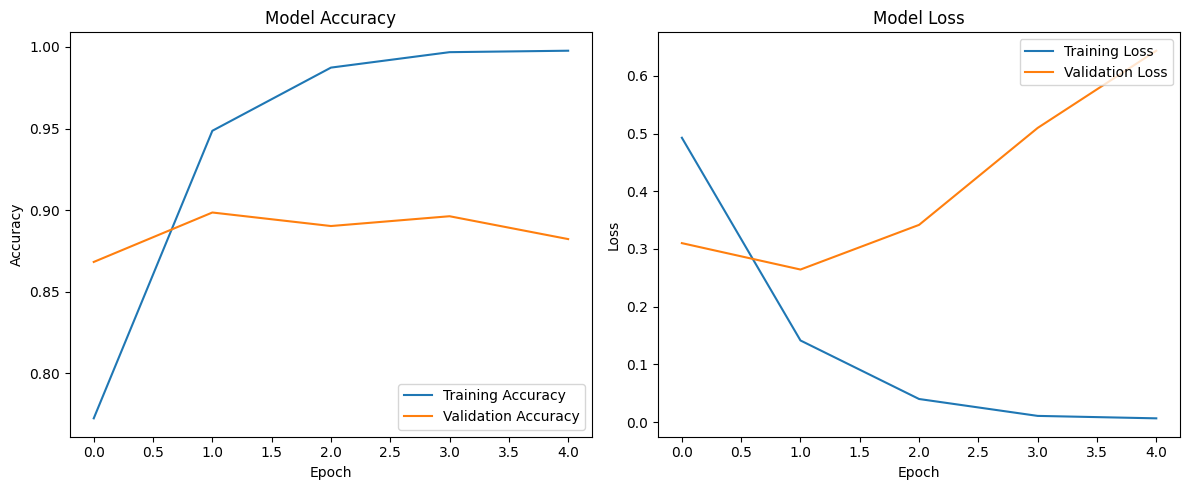

In [ ]:
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 248ms/step - accuracy: 0.8943 - loss: 0.5793
Accuracy: 89.05%


In [34]:
probabilities = model.predict(X_test)

predictions = (probabilities > 0.5).astype(int).ravel()

print(predictions[:10])


469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 242ms/step
[0 1 0 1 1 0 1 1 1 1]


In [35]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.92      0.85      0.89      7490
    positive       0.86      0.93      0.89      7510

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



,negative,positive
negative,6393,1097
positive,546,6964


In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Ensure this is imported

# Function to preprocess a single raw text (uses existing utility functions)
def preprocess_single_text(text):
    # Use existing utility functions for preprocessing
    text = strip_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    text = text.lower()
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)  # Remove special characters
    text = re.sub(' +', ' ', text)  # Remove extra spaces
    text = text.strip()
    return text

# Function to predict sentiment for a raw text
def predict_sentiment(raw_text):
    # Preprocess the input text
    norm_text = preprocess_single_text(raw_text)

    # Convert to sequence using the tokenizer
    sequence = t.texts_to_sequences([norm_text])

    # Pad the sequence to the same length as the training data
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)  # Corrected this line

    # Predict sentiment probability
    probability = model.predict(padded_sequence)[0][0]

    # Convert probability to a class label
    sentiment = "positive" if probability > 0.5 else "negative"

    return sentiment, probability

# Example usage
new_text = "The plot was really bad.. i did not like watching the movie."
sentiment, probability = predict_sentiment(new_text)

print(f"Sentiment: {sentiment}")
print(f"Probability: {probability:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sentiment: negative
Probability: 0.02
